In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020


In [ ]:
cd '/content/drive/My Drive/Fall 2020/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/.shortcut-targets-by-id/14ZkfgKUfI9-nZAJWWGVmgLO13Hh-rZJL/NYU_Team18_Accern_Capstone_Fall2020


In [3]:
!pip install transformers
!pip install pytorch-lightning==1.0.8

     |████████████████████████████████| 1.4MB 8.7MB/s 
     |████████████████████████████████| 2.9MB 24.3MB/s 
     |████████████████████████████████| 890kB 49.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fde4a3235f38f5754971a8e629db148c7c910e481dd4ec56819b4c9fbf349602
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 563kB 7.8MB/s 
     |████████████████████████████████| 276kB 16.5MB/s 
     |████████████████████████████████| 829kB 16.4MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=df75b0ad06e6a50f9134fd11b153bb24d354b33a7932dece8d68278a1bb9b2a4
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0

In [4]:
import numpy as np
import pandas as pd
import torch

from read_data import *
from FinSentiment import *

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Train Models

### Train on Correct

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'null'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) + 'full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')


[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model



[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9337
	Weighted Accuracy: 	0.9504
	F1 Score: 		0.9337
	AUC_SCORE[CLS 0]: 	0.9981
	AUC_SCORE[CLS 1]: 	0.9893
	AUC_SCORE[CLS 2]: 	0.9414
	AUC_SCORE[CLS 3]: 	0.9724
	AUC_SCORE[CLS 4]: 	0.9982

Confusion Matrix


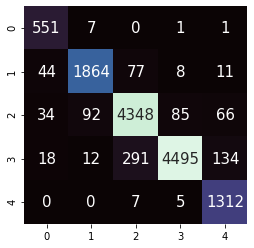

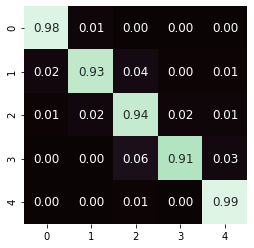

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8332
	Weighted Accuracy: 	0.7997
	F1 Score: 		0.8332
	AUC_SCORE[CLS 0]: 	0.7802
	AUC_SCORE[CLS 1]: 	0.7830
	AUC_SCORE[CLS 2]: 	0.9362
	AUC_SCORE[CLS 3]: 	0.8813
	AUC_SCORE[CLS 4]: 	0.9246

Confusion Matrix


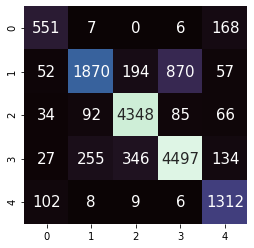

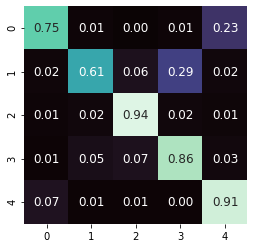

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8479
	Drop Total Sample: 		1089.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9288
	Weighted Accuracy: 	0.9479
	F1 Score: 		0.9288
	AUC_SCORE[CLS 0]: 	0.9971
	AUC_SCORE[CLS 1]: 	0.9903
	AUC_SCORE[CLS 2]: 	0.9357
	AUC_SCORE[CLS 3]: 	0.9705
	AUC_SCORE[CLS 4]: 	0.9983

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


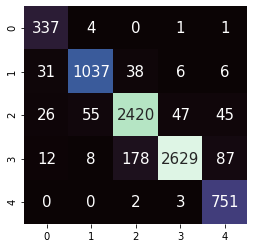

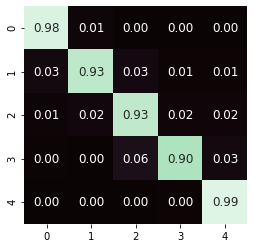

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8219
	Weighted Accuracy: 	0.7876
	F1 Score: 		0.8219
	AUC_SCORE[CLS 0]: 	0.7800
	AUC_SCORE[CLS 1]: 	0.7664
	AUC_SCORE[CLS 2]: 	0.9302
	AUC_SCORE[CLS 3]: 	0.8721
	AUC_SCORE[CLS 4]: 	0.9150

Confusion Matrix


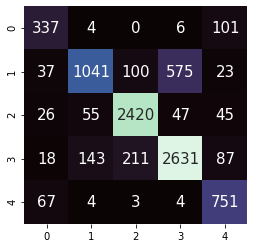

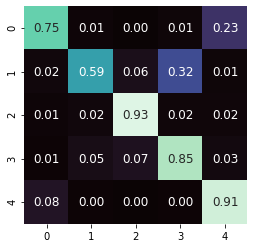

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_null 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8346
	Drop Total Sample: 		645.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Inverse

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'null'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) +'full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (9) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_inverse_null 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9178
	Weighted Accuracy: 	0.9333
	F1 Score: 		0.9178
	AUC_SCORE[CLS 0]: 	0.9932
	AUC_SCORE[CLS 1]: 	0.9105
	AUC_SCORE[CLS 2]: 	0.9825
	AUC_SCORE[CLS 3]: 	0.9607
	AUC_SCORE[CLS 4]: 	0.9969

Confusion Matrix


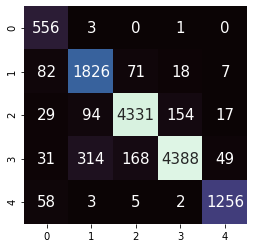

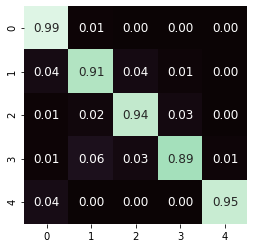

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



--------------------------------------------------------------------------------

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c08b8bbfb21a>", line 1, in <module>
    evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)
  File "/content/drive/.shortcut-targets-by-id/14ZkfgKUfI9-nZAJWWGVmgLO13Hh-rZJL/NYU_Team18_Accern_Capstone_Fall2020/FinSentiment.py", line 603, in evaluate_model
    trainer.test(model, inverse_test_dataloader)
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer.py", line 719, in test
    results = self.__test_given_model(model, test_dataloaders)
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer.py", line 784, in __test_given_model
    results = self.fit(model)
  File "/usr/

RuntimeError: ignored

In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Boundary

In [5]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'null'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method]) + 'full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')


[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model



[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9269
	Weighted Accuracy: 	0.9254
	F1 Score: 		0.9269
	AUC_SCORE[CLS 0]: 	0.9841
	AUC_SCORE[CLS 1]: 	0.9838
	AUC_SCORE[CLS 2]: 	0.9722
	AUC_SCORE[CLS 3]: 	0.9838
	AUC_SCORE[CLS 4]: 	0.9915

Confusion Matrix


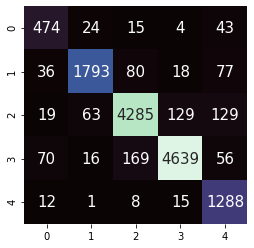

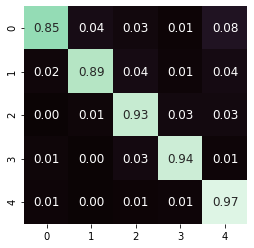

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8429
	Weighted Accuracy: 	0.8287
	F1 Score: 		0.8429
	AUC_SCORE[CLS 0]: 	0.9451
	AUC_SCORE[CLS 1]: 	0.9724
	AUC_SCORE[CLS 2]: 	0.9746
	AUC_SCORE[CLS 3]: 	0.9757
	AUC_SCORE[CLS 4]: 	0.9818

Confusion Matrix


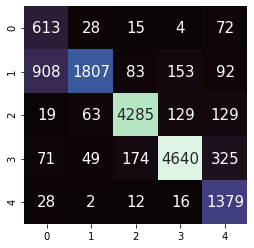

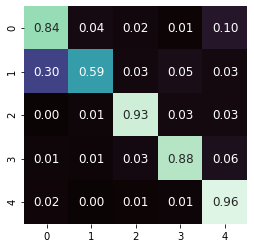

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9512
	Drop Total Sample: 		608.0000
--------------------------------------------------------------------------------



In [6]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9297
	Weighted Accuracy: 	0.9282
	F1 Score: 		0.9297
	AUC_SCORE[CLS 0]: 	0.9823
	AUC_SCORE[CLS 1]: 	0.9876
	AUC_SCORE[CLS 2]: 	0.9732
	AUC_SCORE[CLS 3]: 	0.9839
	AUC_SCORE[CLS 4]: 	0.9925

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


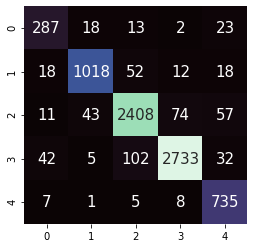

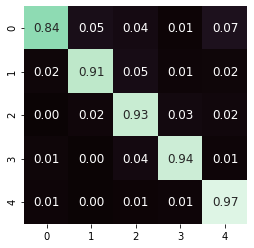

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8385
	Weighted Accuracy: 	0.8222
	F1 Score: 		0.8385
	AUC_SCORE[CLS 0]: 	0.9368
	AUC_SCORE[CLS 1]: 	0.9685
	AUC_SCORE[CLS 2]: 	0.9756
	AUC_SCORE[CLS 3]: 	0.9737
	AUC_SCORE[CLS 4]: 	0.9803

Confusion Matrix


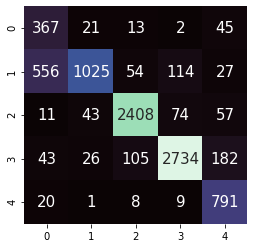

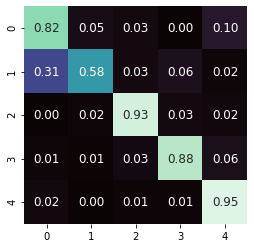

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_null 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9497
	Drop Total Sample: 		368.0000
--------------------------------------------------------------------------------



In [7]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

# Check Best Models

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
company_embedding_method = 'null'

tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1)

In [ ]:
incorrect_type = 'correct'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
incorrect_type = 'inverse'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
incorrect_type = 'boundary'
model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method])
filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '-v0.ckpt'
model = FinSentiment.load_from_checkpoint(filepath)
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments/logs/